# PyCon Namibia 2025 - Malaria Detection with Python

## Abstract

Malaria remains a significant global health challenge, with Africa bearing the highest burden. This workshop explores how AI can assist in malaria detection using deep learning models. Participants will learn to preprocess medical images, build a CNN using TensorFlow, and deploy models in low-resource settings.

## Pre-Requisites

Python Knowledge:

- Intermediate Python programming skills.

- Familiarity with machine learning concepts.

Required Libraries:

- TensorFlow - for building the CNN.

- OpenCV - for image preprocessing.

- Matplotlib - for data visualization.
- sklearn



In [ ]:
pip install tensorflow opencv-python matplotlib tqdm

## The Dataset

Dataset Source: Lacuna Malaria Detection Challenge

### Dataset Description:

- 18,000 labeled images of thick blood smear slides.

- Collected from Uganda and Ghana.

- Annotations include parasite presence and morphological details.

### Key Dataset Components:

- Images: Microscopic blood smear slides.


## Import Libraries

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from tqdm.notebook import tqdm
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import os
import shutil

## Define Data Directory

In [48]:
# Path to where your data is stored
DATA_DIR = Path(r"C:\Users\HP\Downloads\lacuna-malaria-detection-challenge20240829-19463-1cpojqt")

# Preview data files available
os.listdir(DATA_DIR)

['.ipynb_checkpoints',
 'datasets',
 'images',
 'images.zip',
 'Lacuna_Malaria_Detection_Challenge_Starter.ipynb',
 'manifest-c922911ae9101743fc37dc64723c2ee220240829-19463-18lbi0k.json',
 'sampled_images',
 'SampleSubmission.csv',
 'Test.csv',
 'Train.csv',
 'Untitled.ipynb']

## Data Directories

In [51]:
# Images directories
DATASET_DIR = Path('datasets/dataset')
IMAGES_DIR = DATASET_DIR / 'images'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
TEST_IMAGES_DIR = IMAGES_DIR / 'test'

## Load the Data

In [89]:
# Load train and test files
train = pd.read_csv(DATA_DIR / 'Train.csv')
test = pd.read_csv(DATA_DIR / 'Test.csv')

# Add an image_path column
train['image_path'] = [str(Path('images') / x) for x in train.Image_ID]
test['image_path'] = [str(Path('images') / x) for x in test.Image_ID]

# Map str classes to ints (label encoding targets)
train['class_id'] = train['class'].map({'Trophozoite': 0, 'WBC': 1, 'NEG': 2})

# Preview the head of the train set
train.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,image_path,class_id
0,id_u3q6jdck4j.jpg,Trophozoite,1.0,712,1241,737,1270,images\id_u3q6jdck4j.jpg,0
1,id_a6cl90trri.jpg,Trophozoite,1.0,558,1566,600,1604,images\id_a6cl90trri.jpg,0
2,id_qvc2le9sm8.jpg,Trophozoite,1.0,1317,2788,1448,2914,images\id_qvc2le9sm8.jpg,0
3,id_w8xnbd5rvm.jpg,Trophozoite,1.0,925,1744,1041,1823,images\id_w8xnbd5rvm.jpg,0
4,id_6dop09rk02.jpg,NEG,1.0,0,0,0,0,images\id_6dop09rk02.jpg,2


In [90]:
# Remove columns 'confidence', 'ymin', 'xmin', 'ymax', 'xmax' from the train DataFrame
columns_to_remove = ['confidence', 'ymin', 'xmin', 'ymax', 'xmax']
train = train.drop(columns=columns_to_remove, errors='ignore')

In [91]:
train.head()

,Image_ID,class,image_path,class_id
0,id_u3q6jdck4j.jpg,Trophozoite,images\id_u3q6jdck4j.jpg,0
1,id_a6cl90trri.jpg,Trophozoite,images\id_a6cl90trri.jpg,0
2,id_qvc2le9sm8.jpg,Trophozoite,images\id_qvc2le9sm8.jpg,0
3,id_w8xnbd5rvm.jpg,Trophozoite,images\id_w8xnbd5rvm.jpg,0
4,id_6dop09rk02.jpg,NEG,images\id_6dop09rk02.jpg,2


## Map Class Labels to Integers

In [96]:
train['class_id'] = train['class'].map({'Trophozoite': 0, 'WBC': 1, 'NEG': 2})


## Filter Out 'NEG' Images

In [99]:
# Filter out NEG class (Negative images - this images have no Trophozoite nor WBC in them)
train = train[~(train['class'] == 'NEG')].reset_index(drop = True)

Class Distribution:
class
Trophozoite    15838
WBC             7004
NEG              688
Name: count, dtype: int64


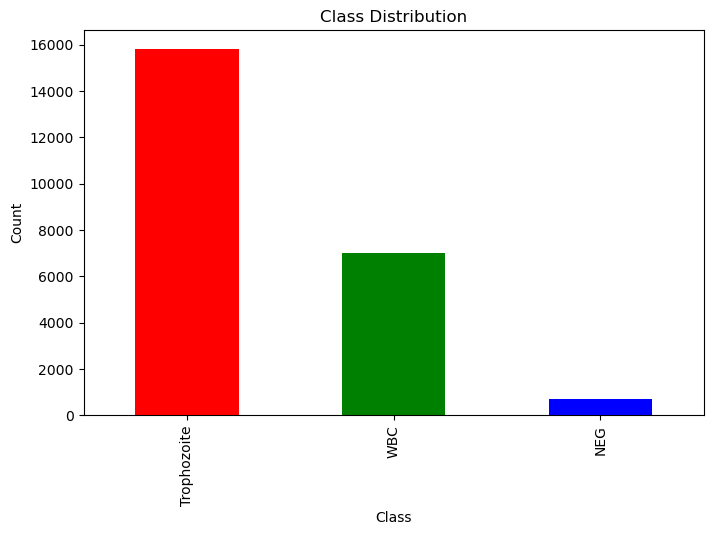

In [101]:
# Check class distribution
class_counts = train_df['class'].value_counts()
print("Class Distribution:")
print(class_counts)

# Plot class distribution
plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color=['red', 'green', 'blue'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### Remove Duplicate Images:

 -  Uses drop_duplicates on the Image_ID column to create train_unique_imgs_df, ensuring each image appears only once.
- The ignore_index=True parameter resets the index of the deduplicated DataFrame.
### Stratified Train-Test Split:

- Applies train_test_split on the unique images with a 75/25 split.
- The stratify=train_unique_imgs_df['class'] argument ensures that the class distribution (Trophozoite and WBC) is maintained in both splits.
- random_state=42 is set for reproducibility of the split.

In [103]:
# Split data into training and validation
train_unique_imgs_df = train.drop_duplicates(subset = ['Image_ID'], ignore_index = True)
X_train, X_val = train_test_split(train_unique_imgs_df, test_size = 0.25, stratify=train_unique_imgs_df['class'], random_state=42)

X_train = train[train.Image_ID.isin(X_train.Image_ID)]
X_val = train[train.Image_ID.isin(X_val.Image_ID)]

# Check shapes of training and validation data
X_train.shape, X_val.shape

((17354, 4), (5488, 4))

## Calculate Class Proportions for Training Data

In [107]:
# Preview target distribution, seems there a class imbalance that needs to be handled
X_train['class'].value_counts(normalize = True), X_val['class'].value_counts(normalize = True)

(class
 Trophozoite    0.688141
 WBC            0.311859
 Name: proportion, dtype: float64,
 class
 Trophozoite    0.709913
 WBC            0.290087
 Name: proportion, dtype: float64)

## Define the Input shape

In [110]:
# Define input shape: adjust these dimensions based on your dataset.
input_shape = (128, 128, 3)

- **Sequential Model Initialization:**  
  - The model is defined as a Keras Sequential model, which allows stacking layers linearly.

- **First Convolutional Layer:**  
  - **Filters:** 7  
  - **Kernel Size:** 3x3  
  - **Activation:** ReLU  
  - **Input Shape:** Uses the predefined `input_shape` (128x128 pixels with 3 channels).  
  - **Padding:** 'same' ensures the output has the same spatial dimensions as the input.

- **Max Pooling Layer:**  
  - **Pool Size:** 2x2  
  - This layer downsamples the feature maps, reducing spatial dimensions and computational complexity.

- **Second Convolutional Layer:**  
  - **Filters:** 12  
  - **Kernel Size:** 2x2  
  - **Activation:** ReLU  
  - **Padding:** 'same' to preserve spatial dimensions.

- **Flatten Layer:**  
  - Converts the 2D feature maps into a 1D vector to prepare for the fully connected layer.

- **Fully Connected (Dense) Layer:**  
  - **Units:** 500  
  - **Activation:** ReLU  
  - Provides a dense layer that learns complex representations from the flattened features.

- **Output Layer:**  
  - **Units:** 1  
  - **Activation:** Sigmoid  
  - Designed for binary classification by outputting a probability between 0 and 1.

In [113]:
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Model Architecture

In [116]:

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 826,529 (3.15 MB)

 Trainable params: 826,529 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

- **Compile the Model:**  
  - Prepares the model for training by specifying the optimizer, loss function, and evaluation metrics.

- **Optimizer - 'adam':**  
  - Uses the Adam optimizer, which adapts the learning rate during training for efficient convergence.

- **Loss Function - 'binary_crossentropy':**  
  - Suitable for binary classification tasks.

- **Metrics - 'accuracy':**  
  - Tracks the proportion of correctly classified samples during training and evaluation.

In [119]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 826,529 (3.15 MB)

 Trainable params: 826,529 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

## Ensure Correct Data Type

In [122]:
# Convert class_id to string type
train['class_id'] = train['class_id'].astype(str)
X_train['class_id'] = X_train['class_id'].astype(str)
X_val['class_id'] = X_val['class_id'].astype(str)


C:\Users\HP\AppData\Local\Temp\ipykernel_6836\3224988315.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['class_id'] = X_train['class_id'].astype(str)
C:\Users\HP\AppData\Local\Temp\ipykernel_6836\3224988315.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['class_id'] = X_val['class_id'].astype(str)


## ImageDataGenerator

In [124]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 500

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255)

print("Preparing training dataset...")
train_generator = datagen.flow_from_dataframe(
    dataframe=X_train,
    directory=str(DATA_DIR),      # Base directory; 'image_path' should be relative to this
    x_col='image_path',           # Column with the image paths
    y_col='class_id',             # Use the binary-mapped labels 
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'           # Binary classification mode
)

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_dataframe(
    dataframe=X_val,
    directory=str(DATA_DIR),
    x_col='image_path',
    y_col='class_id',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

print('Data generators ready')


Getting Data...
Preparing training dataset...
Found 17354 validated image filenames belonging to 2 classes.
Preparing validation dataset...
Found 5488 validated image filenames belonging to 2 classes.
Data generators ready


## Fit the model
-  Use data from Image Data Generator, train and validation
-  The history variable stores training metrics (e.g., loss and accuracy) for each epoch, which can later be used for analysis and visualization.

In [ ]:
# Train the model for 2 epochs
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
)


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
27/35 ━━━━━━━━━━━━━━━━━━━━ 6:38 50s/step - accuracy: 0.6329 - loss: 0.6661 - precision_1: 0.2952 - recall_1: 0.1319

## Test the Model with Unseen Data: Test.cvs